#### Imports

In [1]:
import copy
import itertools
import random
import re
import ast

import numpy as np
import pandas as pd
from Bio import SeqIO
from Bio.Seq import Seq
from matplotlib import pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve

/home/de64/micromamba/envs/crispri/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


#### Functions

In [2]:
## Finds all PAMs on a strand of a sequence record
## strand specifies the strand (1,-1) that the search is being conducted on
## startcoord specifies the beginning coordinate of the seqrecord on the underlying reference genome
def find_strand_pams(seqrecord, strand, startcoord=0):
    if strand == 1:
        seq = str(seqrecord.seq)
    else:
        seq = str(seqrecord.seq.reverse_complement())

    pam_reg = re.compile("(?=(CC))")  ## corrected to get overlapping PAMs as well
    pam_starts = [item.start(0) for item in re.finditer(pam_reg, str(seq))]

    pam_list = []

    if strand == 1:
        for item in pam_starts:
            if len(seq[item + 3 : item + 23]) == 20:
                start = startcoord + item + 3
                end = startcoord + item + 23
                sequence = seq[item + 3 : item + 23]
                pam_list.append([start, end, sequence, strand])
    else:
        for item in pam_starts:
            if len(seq[item + 3 : item + 23]) == 20:
                start = startcoord + len(seq) - item - 23
                end = startcoord + len(seq) - item - 3
                sequence = seq[item + 3 : item + 23]
                pam_list.append([start, end, sequence, strand])
    return pam_list


## Finds all PAMs in target sequence record
## startcoord specifies the beginning coordinate of the seqrecord on the underlying reference genome
## target_strand specifies the strand (1,-1) that the seq record is on
def find_pams(seqrecord, startcoord=0, target_strand=1):
    fwd_pams = find_strand_pams(seqrecord, 1, startcoord=startcoord)
    rev_pams = find_strand_pams(seqrecord, -1, startcoord=startcoord)
    pam_df = pd.DataFrame(
        fwd_pams + rev_pams, columns=["start", "end", "sequence", "ref_strand"]
    )
    if target_strand == 1:
        pam_df["target_strand"] = 1
    else:
        pam_df["target_strand"] = -pam_df["ref_strand"]
    pam_df = pam_df.reset_index()
    pam_df["targetid"] = pam_df["index"]
    del pam_df["index"]
    return pam_df


## Uses a reference csv of bad seeds to eliminate bad seeds from the PAM DataFrame
def remove_bad_seeds(
    pam_df,
    bad_seed_list=[
        "AGGAA",
        "TGACT",
        "ACCCA",
        "AAAGG",
        "GAGGC",
        "CGGAA",
        "ATATG",
        "AACTA",
        "TGGAA",
        "CACTC",
        "GTATA",
        "TATAG",
        "GACTC",
        "GGGAC",
        "ATACA",
        "GAGAA",
        "GGGAA",
        "CAATA",
        "ATTAA",
        "CACCA",
        "AGGGG",
        "AAGGA",
        "CGACT",
        "CGGGC",
        "ATCAG",
        "ATGAA",
        "TAGTT",
        "GGGGT",
        "TATAA",
        "CAATC",
    ],
):
    #     bad_seed_df = pd.read_csv(bad_seed_path)# HERE
    #     bad_seed_list = bad_seed_df["seeds"].tolist()
    ## reverse complement to match target sequence
    pam_df = pam_df[
        pam_df["sgRNA Sequence"].apply(lambda x: x[-5:] not in bad_seed_list)
    ]
    return pam_df


### Convert a target sequence to a spacer sequence
def target_to_spacer(target_str):
    target = Seq(target_str.upper())
    spacer = target.reverse_complement()
    spacer = str(spacer)
    return spacer


def check_restriction_site(in_str, rest_str="GGTCTC"):
    test_str = Seq(in_str.upper())
    rc_test_str = test_str.reverse_complement()
    if (rest_str in test_str) or (rest_str in rc_test_str):
        return True
    else:
        return False


def check_all_sites(in_str, rest_strs=["GAAGAC", "CGTCTC", "GGTCTC"]):
    out_test = False
    for rest_str in rest_strs:
        rest_site = check_restriction_site(in_str, rest_str=rest_str)
        out_test = out_test or rest_site
    return out_test


### Generate a mismatch series of the target query with num_mismatch substitutions starting from the PAM distal end
def generate_mismatch_series(in_str, mismatch_ns):
    flip_dict = {
        "A": ["T", "C", "G"],
        "T": ["A", "C", "G"],
        "C": ["T", "A", "G"],
        "G": ["T", "C", "A"],
    }

    out_series = []
    in_str_len = len(in_str)
    list_str = list(in_str)
    new_str = copy.copy(list_str)
    for i in range(max(mismatch_ns) + 1):
        new_char = np.random.choice(flip_dict[list_str[in_str_len - i - 1]])
        new_str[in_str_len - i - 1] = new_char
        if i in mismatch_ns:
            out_series.append("".join(new_str))
    return out_series


def generate_mismatch_df(pam_df, mismatch_ns=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]):
    mismatch_df = []
    for i, row in pam_df.iterrows():
        targetid = row["EcoWG1_id"]
        sgrna_seq = row["sgRNA Sequence"]
        gene = row["Gene"]
        ref_strand = row["Strand"]
        target_seq = row["Target Sequence"]
        target_sites = row["Target Sites"]
        N_target_sites = row["N Target Sites"]

        rest_test = check_all_sites(sgrna_seq, rest_strs=["GAAGAC", "CGTCTC", "GGTCTC"])
        if not rest_test:
            rest_test_2 = True
            mismatch_df.append(
                [
                    targetid,
                    sgrna_seq,
                    gene,
                    ref_strand,
                    target_seq,
                    target_sites,
                    N_target_sites,
                    0,
                    "Target",
                ]
            )
            while rest_test_2:
                mismatch_list = generate_mismatch_series(target_seq, mismatch_ns)
                rest_test_2 = any(
                    [
                        check_all_sites(
                            mismatch_seq, rest_strs=["GAAGAC", "CGTCTC", "GGTCTC"]
                        )
                        for mismatch_seq in mismatch_list
                    ]
                )
            mismatch_df += [
                [
                    targetid,
                    target_to_spacer(item),
                    gene,
                    ref_strand,
                    target_seq,
                    target_sites,
                    N_target_sites,
                    mismatch_ns[j] + 1,
                    "Target",
                ]
                for j, item in enumerate(mismatch_list)
            ]

    mismatch_df = pd.DataFrame(
        mismatch_df,
        columns=[
            "EcoWG1_id",
            "sgRNA Sequence",
            "Gene",
            "Strand",
            "Target Sequence",
            "Target Sites",
            "N Target Sites",
            "N Mismatch",
            "Category",
        ],
    )
    return mismatch_df


### Add bsai sites and primer sequences to the side for cloning
def add_adaptor_seqs(spacer, target):
    site_1 = "CGTACGACGGAAGACATTAGTCCC"
    site_2 = "TGTTGGAGACGCGTCTCCTAGT"
    site_3 = "GTTTTCGTCTTCTTAAGGTGCC"
    output_seq = site_1 + target + site_2 + spacer + site_3
    return output_seq


## Converts a string to an integer representation
def str_to_int(string):
    code = {"A": 0, "C": 1, "G": 2, "T": 3}
    conv_str = np.array(list(map(lambda x: code[x], string)))
    return conv_str


## Determines the maximum matching (minimum edit distance) of each target sequence
## to sequences in the reference
## subseq_range can be set to subset the sequences to a region of interest (i.e. the PAM adjacent region)
## remove_matching_starts can be set to eliminate sequences from consideration when they are at the same location
def compare_seqs(
    target_df, reference_df, subseq_range=None, remove_matching_starts=True
):
    target_arr = target_df["Target Sequence"].values
    reference_arr = reference_df["sequence"].values
    target_int_arr = np.array(list(map(str_to_int, target_arr)), dtype="uint8")
    reference_int_arr = np.array(list(map(str_to_int, reference_arr)), dtype="uint8")

    if subseq_range != None:
        target_int_arr = target_int_arr[:, subseq_range]
        reference_int_arr = reference_int_arr[:, subseq_range]

    bool_arr = target_int_arr[:, np.newaxis, :] == reference_int_arr[np.newaxis, :, :]
    agreement_arr = np.sum(bool_arr, axis=2, dtype=int)

    if remove_matching_starts:
        matching_starts = np.where(
            target_df["start"].values[:, np.newaxis]
            == reference_df["start"].values[np.newaxis, :]
        )[1]
        agreement_arr[:, matching_starts] = 0
    most_agreement = np.max(agreement_arr, axis=1)
    return most_agreement


# Negative Control: sgRNAs that target nothing
def generate_random_sequences(num_seqs, str_len=20, match_target=False):
    str_arr = np.random.choice(["A", "C", "G", "T"], size=(num_seqs, str_len))
    str_list = np.apply_along_axis("".join, 1, str_arr).tolist()
    if match_target:
        df_out = [
            [k, None, item, None, None, item, None, None, None, "NoTarget"]
            for k, item in enumerate(str_list)
        ]
    else:
        df_out = [
            [
                k,
                None,
                target_to_spacer(item),
                None,
                None,
                item,
                None,
                None,
                None,
                "OnlyPlasmid",
            ]
            for k, item in enumerate(str_list)
        ]

    df_out = pd.DataFrame(
        df_out,
        columns=[
            "TargetID",
            "EcoWG1_id",
            "sgRNA Sequence",
            "Gene",
            "Strand",
            "Target Sequence",
            "Target Sites",
            "N Target Sites",
            "N Mismatch",
            "Category",
        ],
    )
    return df_out

def find_loc(search_str, strand, reference=str(genome.seq)):
    ref_len = len(reference)
    comp_search_str = str(Seq(search_str).reverse_complement())
    search = re.finditer(search_str, reference)
    comp_search = re.finditer(comp_search_str, reference)
    start_end_list = []
    for item in search:
        start_end_list.append((item.start(), item.end(), "+"))
    for item in comp_search:
        start_end_list.append((ref_len - item.end(), ref_len - item.start(), "-"))
    return start_end_list

#### EcoWG1 Data

In [3]:
EcoWG1 = pd.read_csv("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/lDE20_Design/EcoWG1_data.csv")

In [4]:
EcoWG1

,Unnamed: 0,T1,T2,T3,T4,gene,ori
0,GGAAGGGTGGCTTCGAGCGT,-0.318812,-0.715367,-1.929731,-2.313596,nuoF,-
1,GATCGCCGGAACGTTACACA,0.068076,-0.338745,-1.623424,-1.972200,nuoF,-
2,CCGGAGGTTGCCGGGAAGGG,-0.102250,-0.542420,-1.929249,-1.131536,nuoF,-
3,ACTTCCGTGCCATCAATAAA,-0.050367,0.163559,0.247522,0.313455,sufA,-
4,GCCACAGCCACATTCATTCT,0.161503,0.323315,0.230441,0.648901,sufA,-
...,...,...,...,...,...,...,...
21254,CTTTCCTACCCGGCTAGACA,0.108914,0.191725,0.468964,0.070367,Control046,Control046
21255,AACCCAAGGGCACTAGGACC,0.202537,0.302506,0.231408,0.537579,Control047,Control047
21256,ATACTGCAGACACGATCTAG,0.071556,0.140665,0.255259,0.068916,Control048,Control048
21257,GATGAATAAAGTATCTAGCA,0.042902,0.199971,0.217050,0.325301,Control049,Control049


#### TraDIS Data

In [6]:
TraDIS = pd.read_csv("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/lDE20_Design/Goodall_TraDIS.csv", sep=";")

In [7]:
TraDIS

,Gene,index_score,Log_Likelihood_Ratio,Essential,Non-essential,Unclear
0,thrL,0.393939,31.431059,False,True,False
1,thrA,0.219245,17.200782,False,True,False
2,thrB,0.265809,21.234549,False,True,False
3,thrC,0.205905,15.994924,False,True,False
4,yaaX,0.225589,17.765507,False,True,False
...,...,...,...,...,...,...
4308,creC,0.220351,17.299624,False,True,False
4309,creD,0.221729,17.422589,False,True,False
4310,arcA,0.097629,4.641238,False,True,False
4311,yjjY,0.219858,17.255613,False,True,False


In [8]:
essential_TraDIS = TraDIS[TraDIS["Essential"]]
essential_TraDIS_list = essential_TraDIS["Gene"].to_list()

gene_synonyms = pd.read_csv("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/lDE20_Design/gene_synonyms.csv", skiprows=1)
gene_synonyms.columns = ["EcoWG1", "TraDIS"]
gene_synonyms_Eco_to_Trad = {
    key: val
    for entry in gene_synonyms.apply(
        lambda x: {x["EcoWG1"]: x["TraDIS"]}, axis=1
    ).tolist()
    for key, val in entry.items()
}
gene_synonyms_Trad_to_Eco = {val: key for key, val in gene_synonyms_Eco_to_Trad.items()}

essential_TraDIS_list_Eco = [
    gene_synonyms_Trad_to_Eco[item]
    for item in essential_TraDIS_list
    if item in gene_synonyms_Trad_to_Eco.keys()
]

TraDIS_essential_mask = EcoWG1["gene"].isin(essential_TraDIS_list_Eco)
EcoWG1["TraDIS Essential"] = TraDIS_essential_mask
EcoWG1_TraDIS_essential = EcoWG1[TraDIS_essential_mask]
EcoWG1_TraDIS_nonessential = EcoWG1[~TraDIS_essential_mask]

EcoWG1_gene_groupby = EcoWG1.groupby("gene").apply(lambda x: np.min(x["T4"]))
EcoWG1_TraDIS_essential_gene_groupby = EcoWG1_TraDIS_essential.groupby("gene").apply(
    lambda x: np.min(x["T4"])
)
EcoWG1_TraDIS_nonessential_gene_groupby = (
    EcoWG1[~TraDIS_essential_mask].groupby("gene").apply(lambda x: np.min(x["T4"]))
)

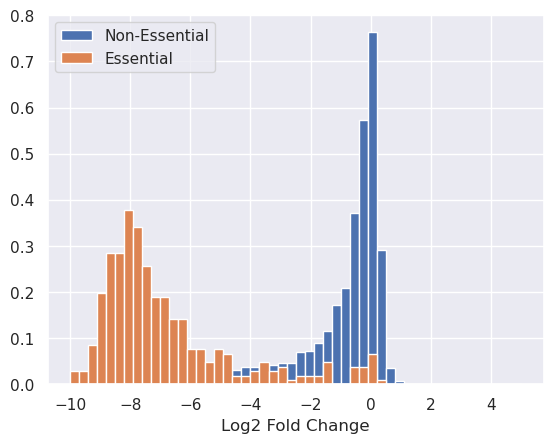

Text(0, 0.5, 'Precision')

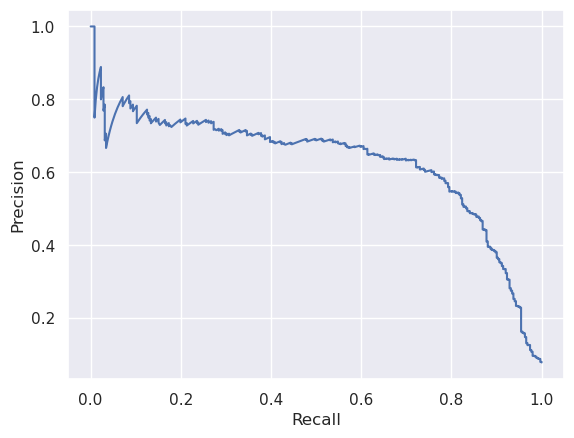

In [9]:
import seaborn as sns

sns.set_theme()

y_true = (
    EcoWG1.groupby("gene")
    .apply(lambda x: np.min(x["TraDIS Essential"]))
    .astype(int)
    .values
)
y_scores = -EcoWG1.groupby("gene").apply(lambda x: np.min(x["T4"])).values
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

plt.hist(
    EcoWG1_TraDIS_nonessential_gene_groupby,
    bins=50,
    range=(-10, 5),
    density=True,
    label="Non-Essential",
)
plt.hist(
    EcoWG1_TraDIS_essential_gene_groupby,
    bins=50,
    range=(-10, 5),
    density=True,
    label="Essential",
)
plt.xlabel("Log2 Fold Change")
plt.legend()
# plt.savefig("./2021-04-28_lab_meeting_fig_1.png", dpi=300)
plt.show()

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
# plt.savefig("./2021-04-28_lab_meeting_fig_2.png", dpi=300)

In [10]:
thr = np.min(-thresholds[recall[1:] > 0.8])

EcoWG1_essential_list = EcoWG1_gene_groupby[EcoWG1_gene_groupby < thr].index.to_list()
EcoWG1_essential_mask = EcoWG1["gene"].isin(
    EcoWG1_essential_list + essential_TraDIS_list_Eco
)
EcoWG1_essential = EcoWG1[EcoWG1_essential_mask]
EcoWG1_nonessential = EcoWG1[~EcoWG1_essential_mask]

EcoWG1_essential = EcoWG1_essential.reset_index(drop=False)
EcoWG1_essential = EcoWG1_essential[["index", "Unnamed: 0", "gene", "ori"]]
EcoWG1_essential.columns = ["EcoWG1_id", "sgRNA Sequence", "Gene", "Strand"]
EcoWG1_essential["Target Sequence"] = [
    str(Seq(item).reverse_complement()) for item in EcoWG1_essential["sgRNA Sequence"]
]

n_genes = len(EcoWG1_essential["Gene"].unique())
print("Guides per gene: " + str(len(EcoWG1_essential) / n_genes))

Guides per gene: 4.7243150684931505


In [11]:
thr

-5.574467017918303

In [13]:
genome = SeqIO.read("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/lDE20_Design/U00096_3.gb", "gb")

In [14]:
EcoWG1_essential["Target Sites"] = EcoWG1_essential.apply(
    lambda x: find_loc(x["Target Sequence"], x["Strand"]), axis=1
)

EcoWG1_essential["N Target Sites"] = EcoWG1_essential["Target Sites"].apply(
    lambda x: len(x)
)
EcoWG1_essential = remove_bad_seeds(EcoWG1_essential)  # some leftover bad seeds?
EcoWG1_essential = generate_mismatch_df(EcoWG1_essential)

EcoWG1_ids = EcoWG1_essential["EcoWG1_id"].unique().tolist()
EcoWG1_ids_to_targetid = dict(zip(EcoWG1_ids, range(len(EcoWG1_ids))))
EcoWG1_essential["TargetID"] = EcoWG1_essential["EcoWG1_id"].apply(
    lambda x: EcoWG1_ids_to_targetid[x]
)

In [ ]:
init_targetid = max(EcoWG1_essential["TargetID"]) + 1
init_index = max(EcoWG1_essential.index) + 1
n_controls = 20
seed_sequence_size = 9

genome = SeqIO.read("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/lDE20_Design/U00096_3.gb", "gb")
genome_pam_df = find_pams(genome)

negative_control_1 = generate_random_sequences(200, match_target=False)
negative_control_1 = remove_bad_seeds(negative_control_1)
no_targets = (
    compare_seqs(
        negative_control_1,
        genome_pam_df,
        subseq_range=range(0, seed_sequence_size),
        remove_matching_starts=False,
    )
    < seed_sequence_size
)
negative_control_1 = negative_control_1[no_targets]
rest_sites = negative_control_1.apply(
    lambda x: check_all_sites(x["sgRNA Sequence"]), axis=1
)
negative_control_1 = negative_control_1[~rest_sites]
negative_control_1 = negative_control_1.sample(n_controls)

negative_control_2 = generate_random_sequences(200, match_target=True)
negative_control_2 = remove_bad_seeds(negative_control_2)
no_targets = (
    compare_seqs(
        negative_control_2,
        genome_pam_df,
        subseq_range=range(0, seed_sequence_size),
        remove_matching_starts=False,
    )
    < seed_sequence_size
)
negative_control_2 = negative_control_2[no_targets]
rest_sites = negative_control_2.apply(
    lambda x: check_all_sites(x["sgRNA Sequence"]), axis=1
)
negative_control_2 = negative_control_2[~rest_sites]
negative_control_2 = negative_control_2.sample(n_controls)

essential_gene_id_list = [7645, 9611]
negative_control_3 = EcoWG1_essential[
    EcoWG1_essential["EcoWG1_id"].isin(essential_gene_id_list)
]
negative_control_3["Target Sequence"] = negative_control_3["sgRNA Sequence"]
negative_control_3["Category"] = "OnlyChr"
del negative_control_3["TargetID"]

non_essential_genes = ["lacZ", "malT", "galM", "mak"]
negative_control_4 = EcoWG1[EcoWG1["gene"].isin(non_essential_genes)].reset_index(
    drop=False
)
negative_control_4 = negative_control_4.drop(
    ["T1", "T2", "T3", "T4", "TraDIS Essential"], axis=1
)
negative_control_4.columns = ["EcoWG1_id", "sgRNA Sequence", "Gene", "Strand"]
negative_control_4["N Mismatch"] = None

negative_control_5 = copy.deepcopy(negative_control_4)

negative_control_4["Target Sequence"] = negative_control_4["sgRNA Sequence"].apply(
    target_to_spacer
)
negative_control_4["Target Sites"] = negative_control_4.apply(
    lambda x: find_loc(x["Target Sequence"], x["Strand"]), axis=1
)
negative_control_4["N Target Sites"] = negative_control_4["Target Sites"].apply(
    lambda x: len(x)
)
negative_control_4["Category"] = "NonEssential"

negative_control_5["Target Sequence"] = negative_control_5["sgRNA Sequence"]
negative_control_5["Target Sites"] = negative_control_5.apply(
    lambda x: find_loc(target_to_spacer(x["Target Sequence"]), x["Strand"]), axis=1
)
negative_control_5["N Target Sites"] = negative_control_5["Target Sites"].apply(
    lambda x: len(x)
)
negative_control_5["Category"] = "NonEssentialOnlyChr"

negative_controls = pd.concat(
    [
        negative_control_1,
        negative_control_2,
        negative_control_3,
        negative_control_4,
        negative_control_5,
    ]
)
negative_controls["TargetID"] = np.array(range(len(negative_controls))) + init_targetid
negative_controls = negative_controls.reset_index(drop=True)
negative_controls.index = negative_controls.index + init_index

output_df = pd.concat([EcoWG1_essential, negative_controls], axis=0)

output_df["Sequence To Order"] = output_df.apply(
    lambda x: add_adaptor_seqs(x["sgRNA Sequence"], x["Target Sequence"]), axis=1
)
output_df["bbsi site"] = output_df["Sequence To Order"].apply(
    lambda x: check_restriction_site(x[10:97], rest_str="GAAGAC")
)
output_df["bsmbi site"] = output_df["Sequence To Order"].apply(
    lambda x: check_restriction_site(x[:54], rest_str="CGTCTC")
    or check_restriction_site(x[56:], rest_str="CGTCTC")
)
output_df["bsai site"] = output_df["Sequence To Order"].apply(
    check_restriction_site, rest_str="GGTCTC"
)
no_internal_sites = (
    ~output_df["bbsi site"] & ~output_df["bsai site"] & ~output_df["bsmbi site"]
)
included_df = output_df[no_internal_sites]
removed_df = output_df[~no_internal_sites]
included_df = included_df.reset_index(drop=True)

included_df.to_csv("./2021-04-20_Essential_KO_Lib_df_original.tsv", sep="\t")

In [ ]:
print("Percent Recovered: " + str(np.sum(no_internal_sites) / len(no_internal_sites)))

### Correction

In the original design, the coordinates were misassigned. Here I open and repair the file, to preserve the randomly selected sequences.

In [ ]:
genome = SeqIO.read("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/lDE20_Design/U00096_3.gb", "gb")
reference = str(genome.seq)
ref_len = len(reference)
old_df = pd.read_csv(
    "./2021-04-20_Essential_KO_Lib_df_original.tsv", sep="\t", usecols=range(1, 15)
)
old_df.insert(0, "oDEPool7_id", old_df.index)

In [ ]:
old_df

In [ ]:
old_df["Target Sites"][~old_df["Target Sites"].isna()] = old_df["Target Sites"][
    ~old_df["Target Sites"].isna()
].apply(lambda x: ast.literal_eval(x))

In [ ]:
old_df["Target Sites"][~old_df["Target Sites"].isna()] = old_df["Target Sites"][
    ~old_df["Target Sites"].isna()
].apply(
    lambda x: [
        (target_site[0] + 1, target_site[1], target_site[2])
        if target_site[2] == "+"
        else (ref_len - target_site[1] + 1, ref_len - target_site[0], target_site[2])
        for target_site in x
    ]
)

In [ ]:
old_df.sample(n=5)

In [ ]:
old_df.to_csv("./2021-04-20_Essential_KO_Lib_df_coords_corrected.tsv", sep="\t")